# Assignment 3: Machine Learning and Prediction

For this assignment, we use a data set obtained from the UC Irvine Machine Learning Repository, which contains information related to a direct marketing campaign of a Portuguese banking institution and its attempts to get its clients to subscribe for a term deposit.

The data is available at: `'https://github.com/mariuszoican/mgt443/blob/main/Data/A4_bank-additional-full_v2.csv?raw=true'`.

| Variable     | Description                                              | Type                |
|--------------|----------------------------------------------------------|---------------------|
| `age`        | Client age                                               | Numeric             |
| `job`        | Occupation of client                                     | Categorical         |
| `marital`    | Marital status                                           | Categorical         |
| `education`  | Education level                                          | Categorical         |
| `default`    | Client has credit in default?                            | Categorical         |
| `housing`    | Client has housing loan?                                 | Categorical         |
| `loan`       | Client has personal loan?                                | Categorical         |
| `contact`    | Contact communication type                               | Categorical         |
| `month`      | Month that last contact was made                         | Categorical         |
| `day_of_week`| Day that last contact was made                           | Categorical         |
| `duration`   | Duration of last contact in seconds                      | Numeric             |
| `campaign`   | Number of contacts performed during this campaign for the client | Numeric    |
| `pdays`      | Number of days since client was last contacted in a previous campaign | Numeric |
| `poutcome`   | Outcome of the previous marketing campaign               | Categorical         |
| `y`          | Outcome of this campaign: Client has subscribed to a term deposit? | Binary (Yes or No) |


Your main task is to build a **logistic regression** model to predict which variables predict whether clients subscribe or not for a term deposit.

1. Many variables are categorical (e.g., `job` is either `admin`, `blue-collar`, `entrepreneur`, etc.). Since you cannot use them in regressions, you need to create dummy variables for each categorical value of each variable. For example, the processed dataset will contain a column `job_admin` taking value 1 if the job is admin, and zero else.

2. Estimate the logistic regression on the first half of the data set (training sample). Report the estimated coefficients, comment briefly on the sign of coefficients (choose one or two variables to comment on.)

3. Test your model on the second half of the data set. Plot the Receiver Operating Characteristic curve and compute the AUC. How good is your predictive power?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.optimize as spo
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score, f1_score)

In [2]:
link = 'https://github.com/mariuszoican/mgt443/blob/main/Data/A4_bank-additional-full_v2.csv?raw=true'
dataset = pd.read_csv(link)
dataset

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,yes


In [3]:
# Place all categorical columns in list
categorical_columns = ['job', 'marital', 'education', 'default', 'housing','loan', 
                       'contact', 'month', 'day_of_week', 'poutcome']

# Generate dummy variables for all categorical columns
dummies = pd.get_dummies(dataset[categorical_columns])

# Concat the dummy variables and drop original columns
dataset = pd.concat([dataset.drop(categorical_columns, axis=1), dummies.astype(int)], axis=1)

# Convert to booleans
dataset['y'] = dataset['y'].map({'yes': 1, 'no': 0})
dataset

,age,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
41184,46,383,1,999,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
41185,56,189,2,999,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
41186,44,442,1,999,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [4]:
dataset.groupby('y').count()

,age,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
y,,,,,,,,,,,,,,,,,,,,,
0,36548,36548,36548,36548,36548,36548,36548,36548,36548,36548,...,36548,36548,36548,36548,36548,36548,36548,36548,36548,36548
1,4640,4640,4640,4640,4640,4640,4640,4640,4640,4640,...,4640,4640,4640,4640,4640,4640,4640,4640,4640,4640


In [5]:
# Choose features
X = dataset.drop('y',axis=1)

# Target Variable
Y = dataset["y"]

# Split ratio and random seed
test_size = 0.50
seed = 10

# Split dataset into training and testing sets, with stratification to maintain the distribution of 'y'
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed, stratify=Y)

### Alphas and Betas

In [6]:
# Create an instance of Logistic Regression
lgstc_reg = LogisticRegression(solver='newton-cg')

# Fit training data on Logistic Regression 
lgstc_reg.fit(X_train, Y_train)

# Print coefficients
print("Intercept:", lgstc_reg.intercept_)
print("Coefficients:", lgstc_reg.coef_)

Intercept: [-2.18144264]
Coefficients: [[ 4.36508478e-03  4.27678475e-03 -5.91340268e-02 -1.40237501e-03
   1.55014016e-01 -4.40861485e-02 -3.33487044e-01 -3.47461955e-01
  -2.26994895e-01 -2.01378563e-01  6.86135678e-01 -6.32796683e-02
  -3.33350789e-01  8.01755678e-01 -1.89005905e-01  2.43328687e-01
   7.82490453e-03  1.22394756e-02  1.45342903e-01  2.27615109e-01
  -3.85197507e-01 -2.69688537e-01  1.34987859e-02 -2.64194852e-01
  -1.83448954e-01  5.69755414e-01 -1.29570995e-02  1.22773914e-01
   2.42613085e-02  3.65376049e-01 -3.07613913e-01 -5.77621567e-02
   7.39423673e-02 -1.27596822e-01  5.36544345e-02  5.56038236e-02
  -1.27596822e-01  7.19929782e-02  5.07915216e-01 -5.07915236e-01
  -6.37422980e-02 -8.71196251e-01  6.56161858e-01 -8.99751892e-01
  -2.58887365e-02  1.54878113e+00 -9.70505274e-01 -8.96741750e-01
   8.76810179e-01  6.46073016e-01 -8.20087755e-02 -1.22414020e-01
  -3.53265595e-02  8.31386505e-02  1.56610684e-01 -3.96770165e-01
  -2.80911387e-01  6.77681532e-01]]


### Shows which coefficient corresponds to which column

In [7]:
# Extract the column names from X_train
feature_names = list(X_train.columns)

# Extract the coefficients for the logistic regression model and flatten the array
coefficients = lgstc_reg.coef_.flatten()

# Create the dictionary using a dictionary comprehension
coefficients_dict = {feature_names[i]: coefficients[i] for i in range(len(feature_names))}

# Print the dictionary
print(coefficients_dict)

{'age': 0.004365084784624833, 'duration': 0.004276784753341051, 'campaign': -0.059134026767472356, 'pdays': -0.0014023750054280289, 'previous': 0.15501401560901104, 'job_admin.': -0.044086148492370004, 'job_blue-collar': -0.33348704366171134, 'job_entrepreneur': -0.3474619551705413, 'job_housemaid': -0.22699489531103653, 'job_management': -0.20137856330015752, 'job_retired': 0.6861356784999959, 'job_self-employed': -0.06327966828066402, 'job_services': -0.3333507894691985, 'job_student': 0.801755678316048, 'job_technician': -0.18900590508394355, 'job_unemployed': 0.24332868738455127, 'job_unknown': 0.007824904530302967, 'marital_divorced': 0.012239475574782124, 'marital_married': 0.1453429026066534, 'marital_single': 0.2276151090889258, 'marital_unknown': -0.38519750730922436, 'education_basic.4y': -0.26968853669728077, 'education_basic.6y': 0.013498785857531202, 'education_basic.9y': -0.2641948523124757, 'education_high.school': -0.18344895401476863, 'education_illiterate': 0.56975541

Some of the coefficients of the logistic regression are:

1. 0.004365084784624833 for age </br>
(age <span style="color:green">**increases**</span> likelihood of a term deposit subscription)

2. -0.059134026767472356 for campaign </br>
(more frequent contacts to a particular customer <span style="color:red">**decreases**</span> likelihood of a term deposit subscription)

3. 0.8768101790106312 for month_oct </br>
(campaigns done in October have <span style="color:green">**more**</span> likelihood of a term deposit subscription)

4. 0.6776815316314226 for poutcome_success </br>
(past customers from previous campaigns have <span style="color:green">**more**</span> likelihood of a term deposit subscription)

### Shows distribution of the probabilities of success

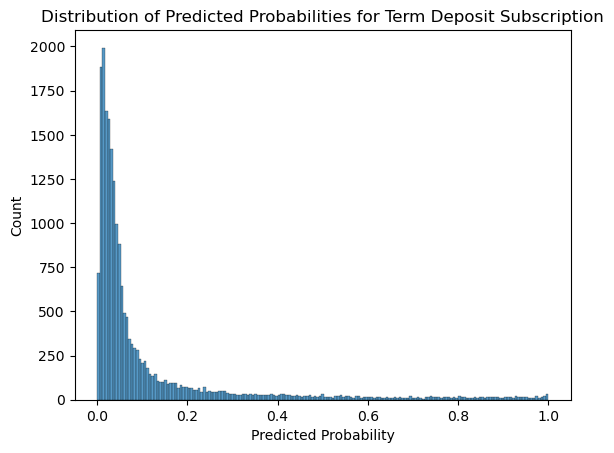

In [8]:
sns.histplot(data=lgstc_reg.predict_proba(X_test)[:,1])

# Adding the plot title
plt.title('Distribution of Predicted Probabilities for Term Deposit Subscription')

# (Optional) Adding labels for the axes
plt.xlabel('Predicted Probability')
plt.ylabel('Count')

# Display the plot
plt.show()

The distribution is positively skewed, which suggests that most people have low probability of subscribing to a term deposit given a campaign.

### Receiver Operating Characteristic Curve & Area Under Curve (AUC)

AUC for our predictive model:  0.914675292388281
AUC for random model:  0.5
AUC for perfect model:  1.0


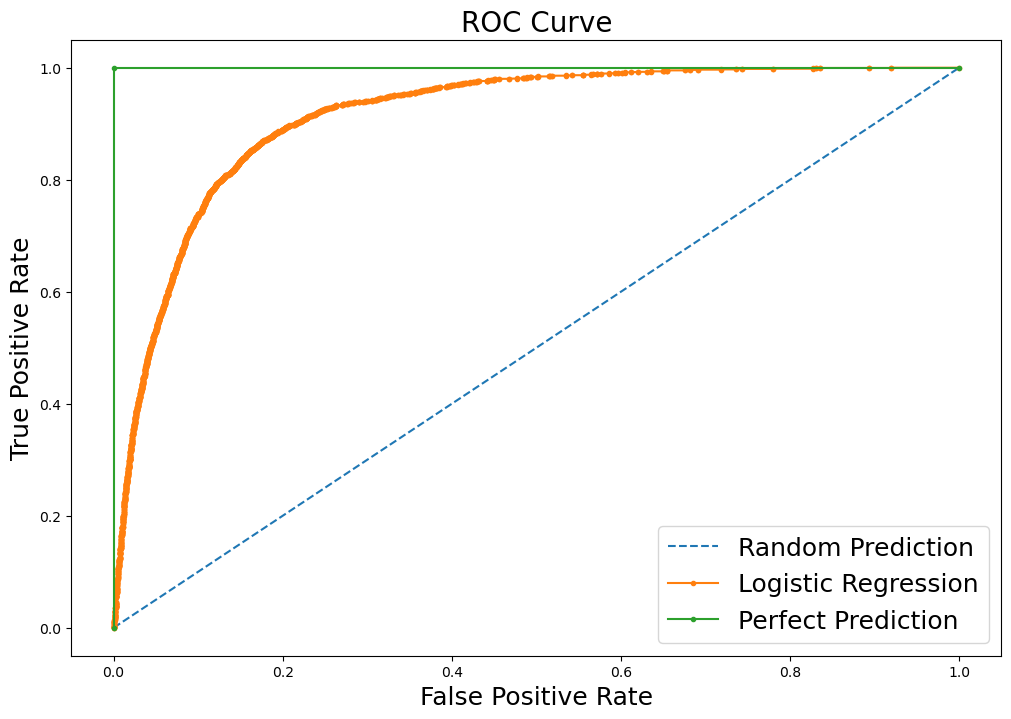

In [9]:
## PREDICTED SUCCESS PROBABILITIES
lr_prob=lgstc_reg.predict_proba(X_test)
lr_prob=lr_prob[:, 1]

# compute AUC score for predictive model
lr_auc=roc_auc_score(Y_test,lr_prob) 
lr_fpr,lr_tpr,_=roc_curve(Y_test,lr_prob) # ROC curve for predictive model


## An uninformative model: always predict default 

ns_prob=[0 for _ in range(len(Y_test))] # a "dummy" model: predict outcome 0 (default), regardless.
ns_auc=roc_auc_score(Y_test,ns_prob) # compute AUC score for random model
ns_fpr,ns_tpr,_=roc_curve(Y_test,ns_prob) # ROC curve for random model

## A perfect model: predict default only when it has happened (hindsight!)

hind_prob=Y_test
hind_auc=roc_auc_score(Y_test,hind_prob)
hind_fpr,hind_tpr,_=roc_curve(Y_test,hind_prob) # ROC curve for random model

print("AUC for our predictive model: ",lr_auc)
print("AUC for random model: ",ns_auc)
print("AUC for perfect model: ",hind_auc)


plt.figure(figsize=(12,8))

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random Prediction')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
plt.plot(hind_fpr, hind_tpr, marker='.', label='Perfect Prediction')

plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=20)  # Adding a title to the ROC curve plot
plt.legend(fontsize=18)
plt.show()

The closer the logistic regression is to the perfect prediction, the better the model is.

The AUC (Area Under Curve) for the predictive model is **0.914675292388281**, which is significantly higher than 0.5. An AUC closer to 1 indicates excellent model performance, suggesting that the logistic regression model has strong discriminative power to distinguish between clients who will subscribe to a term deposit and those who will not given a campaign contact. Hence, the banking institution can now effectively identify potential subscribers to term deposits among the bank's clients, which is valuable for directing marketing efforts more efficiently.

### Cost of False Positives

Let $c\geq 1$ be the relative cost of wasted marketing efforts and resources.

Let $Z$ be the decision threshold for classifying whether a client will subscribe to a term deposit or not, based on the likelihood that a client will subscribe given a campaign.

As a term deposit officer, you want to maximize:
$$ \max_{Z} \text{TruePositive}\left(Z\right)-c\times\text{FalsePositive}\left(Z\right)$$

In [10]:
def campaign_success_metric(Z, c):

    # Predictions based on the threshold Z
    preds = np.where(lgstc_reg.predict_proba(X_test)[:, 1] > Z, 1, 0)
    
    # Confusion matrix normalized by the number of instances in Y_test
    cm = confusion_matrix(Y_test, preds, labels=[1, 0]) / len(Y_test) * 100
    
    # True Positives and False Positives
    TP = cm[0][0]
    FP = cm[1][0]
    
    # Campaign success metric
    return TP - c * FP

def opt_z(c):
    
    # Search space for Z
    z_space = np.linspace(0, 1, 100)
    
    # Initial brute force search
    z_brute_force = z_space[np.argmax([campaign_success_metric(zi, c) for zi in z_space])]
    
    # Refine search using optimization
    optimal_z = spo.fmin(lambda x: -campaign_success_metric(x, c), z_brute_force, ftol=10**-4)
    
    return optimal_z

In [11]:
c_space = np.linspace(0, 3, 10)
# Finding optimal Z for each cost
optimal_z_values = [opt_z(ci) for ci in c_space]

Optimization terminated successfully.
         Current function value: -11.265417
         Iterations: 3
         Function evaluations: 8
Optimization terminated successfully.
         Current function value: -5.380208
         Iterations: 8
         Function evaluations: 18
Optimization terminated successfully.
         Current function value: -3.076948
         Iterations: 11
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: -1.976304
         Iterations: 9
         Function evaluations: 21
Optimization terminated successfully.
         Current function value: -1.244699
         Iterations: 11
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -0.681428
         Iterations: 10
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: -0.286491
         Iterations: 12
         Function evaluations: 27
Optimization terminated succes

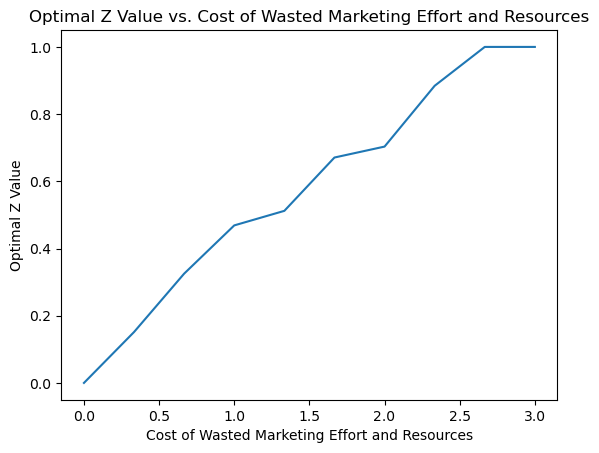

In [12]:
plt.plot(c_space,optimal_z_values)

# Adding labels
plt.xlabel('Cost of Wasted Marketing Effort and Resources')
plt.ylabel('Optimal Z Value')
plt.title('Optimal Z Value vs. Cost of Wasted Marketing Effort and Resources')

# Display the updated plot
plt.show()

The graph illustrates that as the cost of wasted marketing efforts rises, the model's optimal threshold ($Z$) for predicting client subscriptions also increases. This reflects a strategic shift towards more conservative predictions, minimizing the risk of costly false positives by demanding higher confidence in a client's likelihood to subscribe.

### Confusion Matrices

**Assume $c$ = 2.0**

In [13]:
opt_z(2.0)

Optimization terminated successfully.
         Current function value: -0.286491
         Iterations: 12
         Function evaluations: 27


array([0.70336766])

If the cost of wasted marketing efforts is 2.0, the model's optimal threshold ($Z$) for predicting client subscriptions is **0.70336766**. Under such conditions, the confusion matrices looks like:

In [14]:
# List of threshold values to evaluate
Z_values = [0, 0.70336766, 1]

results_list = []

# Loop over each threshold value
for Z in Z_values:
    # Predict based on the probability threshold Z
    preds = np.where(lgstc_reg.predict_proba(X_test)[:, 1] > Z, 1, 0)
    # Confusion matrix normalized by the number of instances in Y_test
    cm = confusion_matrix(Y_test, preds, labels=[1, 0]) / len(Y_test) * 100
    print('Confusion matrix for threshold =', Z)
    print(cm)
    print(' ')
    
    # Compute evaluation metrics
    accuracy = accuracy_score(Y_test, preds)
    recall = recall_score(Y_test, preds)
    precision = precision_score(Y_test, preds)
    f1 = f1_score(Y_test, preds)

    # True Negatives Rate (Specificity or TNR)
    tnr = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    # True Positive Rate (Sensitivity, Recall, or TPR)
    tpr = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    # False Positive Rate (FPR)
    fpr = cm[1, 0] / (cm[1, 0] + cm[1, 1])

    # Append results to the list
    results_list.append({
        "THRESHOLD": Z,
        "accuracy": accuracy,
        "recall": recall,
        "tnr": tnr,
        'tpr': tpr,
        "fpr": fpr,
        "precision": precision,
        "f1_score": f1
    })

results = pd.DataFrame(results_list)

results

Confusion matrix for threshold = 0
[[11.26541711  0.        ]
 [88.73458289  0.        ]]
 
Confusion matrix for threshold = 0.70336766
[[ 2.5492862   8.71613091]
 [ 1.13139749 87.60318539]]
 
Confusion matrix for threshold = 1
[[ 0.         11.26541711]
 [ 0.         88.73458289]]
 


,THRESHOLD,accuracy,recall,tnr,tpr,fpr,precision,f1_score
0,0.000000,0.112654,1.000000,0.00000,1.000000,1.00000,0.112654,0.202496
1,0.703368,0.901525,0.226293,0.98725,0.226293,0.01275,0.692612,0.341131
2,1.000000,0.887346,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000


| Z=0                                  | Predict positive (subscribe)  | Predict negative (no subscribe) |
|--------------------------------------|-------------------------------|---------------------------------|
| **Outcome positive (subscribe)**     | 11.26541711                   | 0                               |
| **Outcome negative (no subscribe)**  | 88.73458289                   | 0                               |

| Z=0.703368                           | Predict positive (subscribe)  | Predict negative (no subscribe) |
|--------------------------------------|-------------------------------|---------------------------------|
| **Outcome positive (subscribe)**     | 2.5492862                     | 8.71613091                      |
| **Outcome negative (no subscribe)**  | 1.13139749                    | 87.60318539                     |

| Z=1                                  | Predict positive (subscribe)  | Predict negative (no subscribe) |
|--------------------------------------|-------------------------------|---------------------------------|
| **Outcome positive (subscribe)**     | 0                             | 11.26541711                     |
| **Outcome negative (no subscribe)**  | 0                             | 88.73458289                     |

At $Z$=0, all clients will subscribe, resulting in perfect recall but no true negatives, making it impractical given the cost of wasted marketing resources. 

A threshold of $Z$=0.7033368 provides a balanced outcome, improving accuracy to 90.15% and maintaining a substantial true negative rate (98.72%). 

At $Z$=1, the model fails to identify potential subscribers, which is not useful for a predictive model to identify opportunities for marketing term deposits. 

A threshold of $Z$=0.7033368 indicates a model that balances the need to capture potential subscribers while minimizing wasteful marketing efforts on unlikely clients.